In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

100%|██████████| 652k/652k [00:00<00:00, 74.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2
['adult.csv']


##Load Data

In [5]:
df = pd.read_csv(path + '/adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [6]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [7]:
for col in df.columns:
    print(f'{col}: {df[col].unique()}')

age: [25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
workclass: ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
fnlwgt: [226802  89814 336951 ... 129912 255835 257302]
education: ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
educational-num: [ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]
marital-status: ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation: ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Tr

##Feature Engineering

native country to US n Non-US

In [8]:
df['native_country_group'] = np.where(
    df['native-country'] == 'United-States',
    'US',
    'Non-US'
)
df = df.drop(columns=['native-country'])

df.native_country_group.value_counts()

,count
native_country_group,
US,43832
Non-US,5010


replace workclass ? to Unknown

In [9]:
df['workclass_group'] = df['workclass'].replace({
    'Federal-gov': 'Government',
    'State-gov': 'Government',
    'Local-gov': 'Government',
    'Self-emp-not-inc': 'Self-Employed',
    'Self-emp-inc': 'Self-Employed',
    'Without-pay': 'Other',
    'Never-worked': 'Other',
    '?': 'Unknown'
})
df = df.drop(columns=['workclass'])


df.workclass_group.value_counts()

,count
workclass_group,
Private,33906
Government,6549
Self-Employed,5557
Unknown,2799
Other,31


replace occupation ? to Unknown

In [10]:
occupation_map = {
    'Exec-managerial': 'White-Collar',
    'Prof-specialty': 'White-Collar',
    'Adm-clerical': 'White-Collar',
    'Sales': 'White-Collar',

    'Craft-repair': 'Blue-Collar',
    'Machine-op-inspct': 'Blue-Collar',
    'Transport-moving': 'Blue-Collar',
    'Handlers-cleaners': 'Blue-Collar',
    'Farming-fishing': 'Blue-Collar',

    'Priv-house-serv': 'Service',
    'Other-service': 'Service',
    'Protective-serv': 'Service',
    'Tech-support': 'Service',

    'Armed-Forces': 'Military',
    '?': 'Unknown'
}

df['occupation_group'] = df['occupation'].map(occupation_map)
df = df.drop(columns=['occupation'])

df.occupation_group.value_counts()

,count
occupation_group,
White-Collar,23373
Blue-Collar,15051
Service,7594
Unknown,2809
Military,15


In [11]:
df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)
df = df.drop(columns=['capital-gain', 'capital-loss'])

In [12]:
df.has_capital_loss.value_counts()

,count
has_capital_loss,
0,46560
1,2282


In [13]:
df.has_capital_gain.value_counts()

,count
has_capital_gain,
0,44807
1,4035


In [14]:
df['income'] = df['income'].map({
    '<=50K': 0,
    '>50K': 1
})

In [15]:
df = df.drop(columns=['fnlwgt'])
df = df.drop(columns=['education'])

cek ?

In [16]:
df_clean = df.copy()
for col in df_clean.columns:
    print(f'{col}: {df_clean[col].unique()}')

age: [25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
educational-num: [ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]
marital-status: ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
relationship: ['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
race: ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
gender: ['Male' 'Female']
hours-per-week: [40 50 30 32 10 39 35 48 25 20 45 47  6 43 90 54 60 38 36 18 24 44 56 28
 16 41 22 55 14 33 37  8 12 70 15 75 52 84 42 80 68 99 65  5 17 72 53 29
 96 21 46  3  1 23 49 67 76  7  2 58 26 34  4 51 78 63 31 92 77 27 85 13
 19 98 62 66 57 11 86 59  9 64 73 61 88 79 89 74 69 87 97 94 82 91 81 95]
income: [0 1]
native_country_group: ['US' 'Non-US']
workclass_group: 

##EDA

In [17]:
df.info()
df.isnull().sum()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   48842 non-null  int64 
 1   educational-num       48842 non-null  int64 
 2   marital-status        48842 non-null  object
 3   relationship          48842 non-null  object
 4   race                  48842 non-null  object
 5   gender                48842 non-null  object
 6   hours-per-week        48842 non-null  int64 
 7   income                48842 non-null  int64 
 8   native_country_group  48842 non-null  object
 9   workclass_group       48842 non-null  object
 10  occupation_group      48842 non-null  object
 11  has_capital_gain      48842 non-null  int64 
 12  has_capital_loss      48842 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 4.8+ MB


,age,educational-num,marital-status,relationship,race,gender,hours-per-week,income,native_country_group,workclass_group,occupation_group,has_capital_gain,has_capital_loss
count,48842.000000,48842.000000,48842,48842,48842,48842,48842.000000,48842.000000,48842,48842,48842,48842.000000,48842.000000
unique,NaN,NaN,7,6,5,2,NaN,NaN,2,5,5,NaN,NaN
top,NaN,NaN,Married-civ-spouse,Husband,White,Male,NaN,NaN,US,Private,White-Collar,NaN,NaN
freq,NaN,NaN,22379,19716,41762,32650,NaN,NaN,43832,33906,23373,NaN,NaN
mean,38.643585,10.078089,NaN,NaN,NaN,NaN,40.422382,0.239282,NaN,NaN,NaN,0.082613,0.046722
std,13.710510,2.570973,NaN,NaN,NaN,NaN,12.391444,0.426649,NaN,NaN,NaN,0.275300,0.211045
min,17.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000
25%,28.000000,9.000000,NaN,NaN,NaN,NaN,40.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000
50%,37.000000,10.000000,NaN,NaN,NaN,NaN,40.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000
75%,48.000000,12.000000,NaN,NaN,NaN,NaN,45.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000


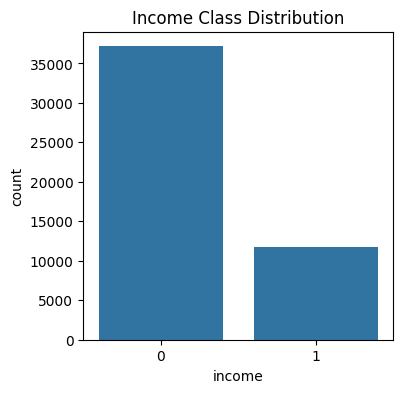

,proportion
income,
0,0.760718
1,0.239282


In [18]:
plt.figure(figsize=(4,4))
sns.countplot(x='income', data=df)
plt.title("Income Class Distribution")
plt.show()

df['income'].value_counts(normalize=True)

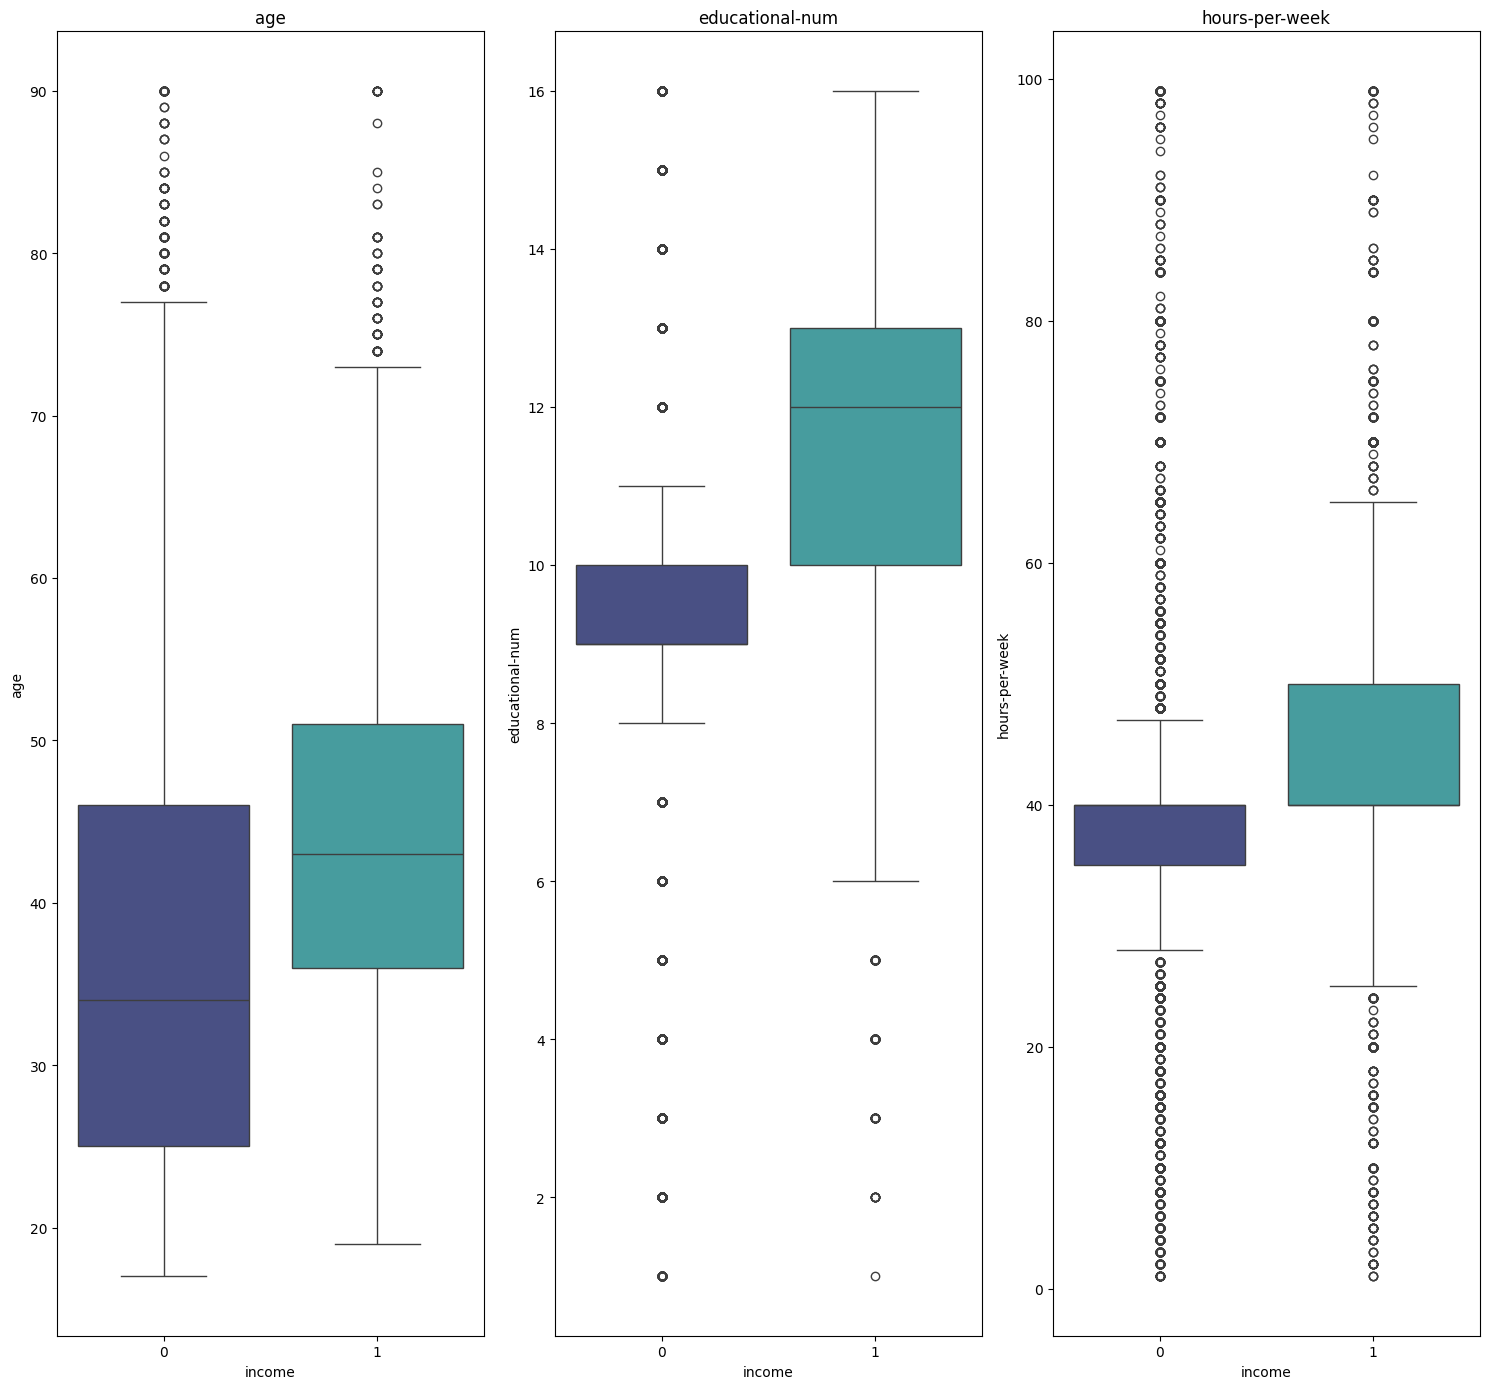

In [19]:
num_cols = [
    'age',
    'educational-num',
    'hours-per-week',
]

plt.figure(figsize=(15,14))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df['income'],
                y=df[col],
                palette="mako",
                )
    plt.title(col)

plt.tight_layout()
plt.show()

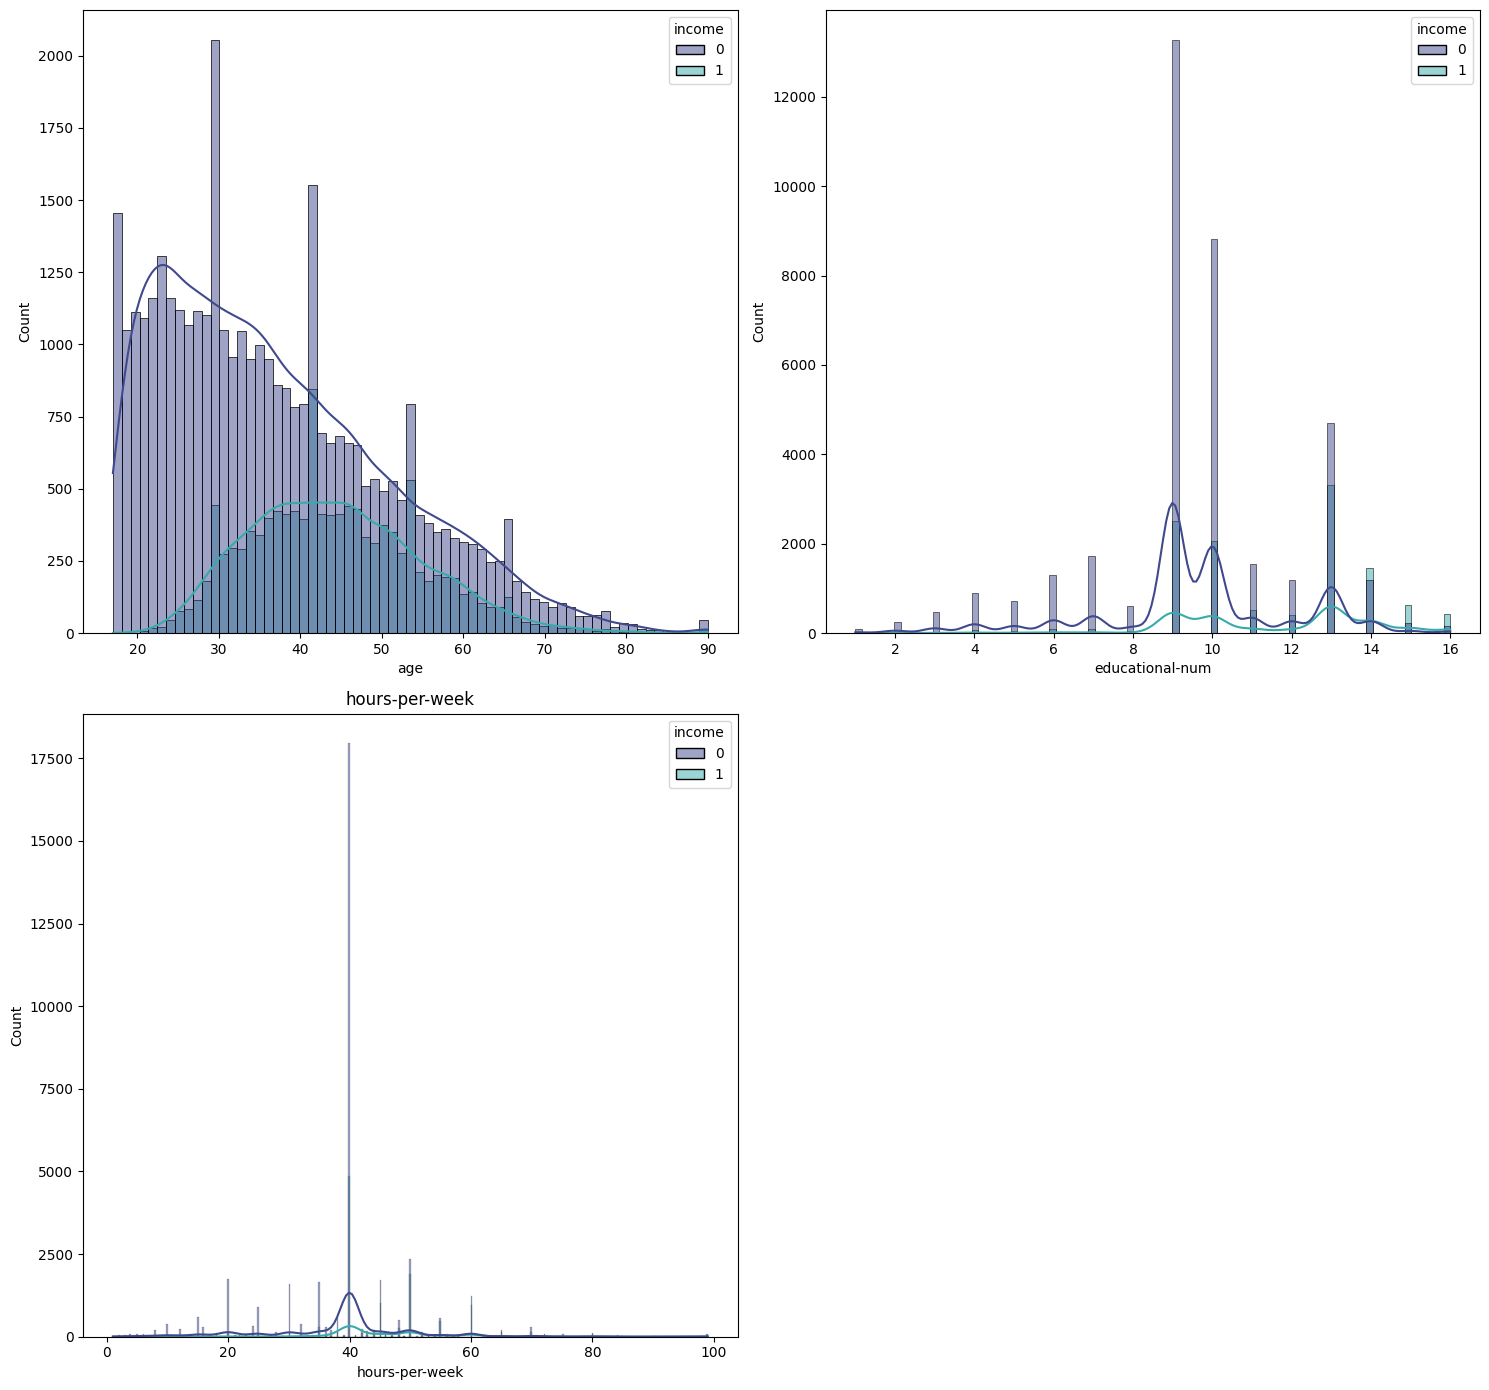

In [20]:
plt.figure(figsize=(15,14))
for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(
      x=df[col],
      hue=df['income'],
      kde=True,
      palette="mako"
  )
plt.title(col)

plt.tight_layout()
plt.show()

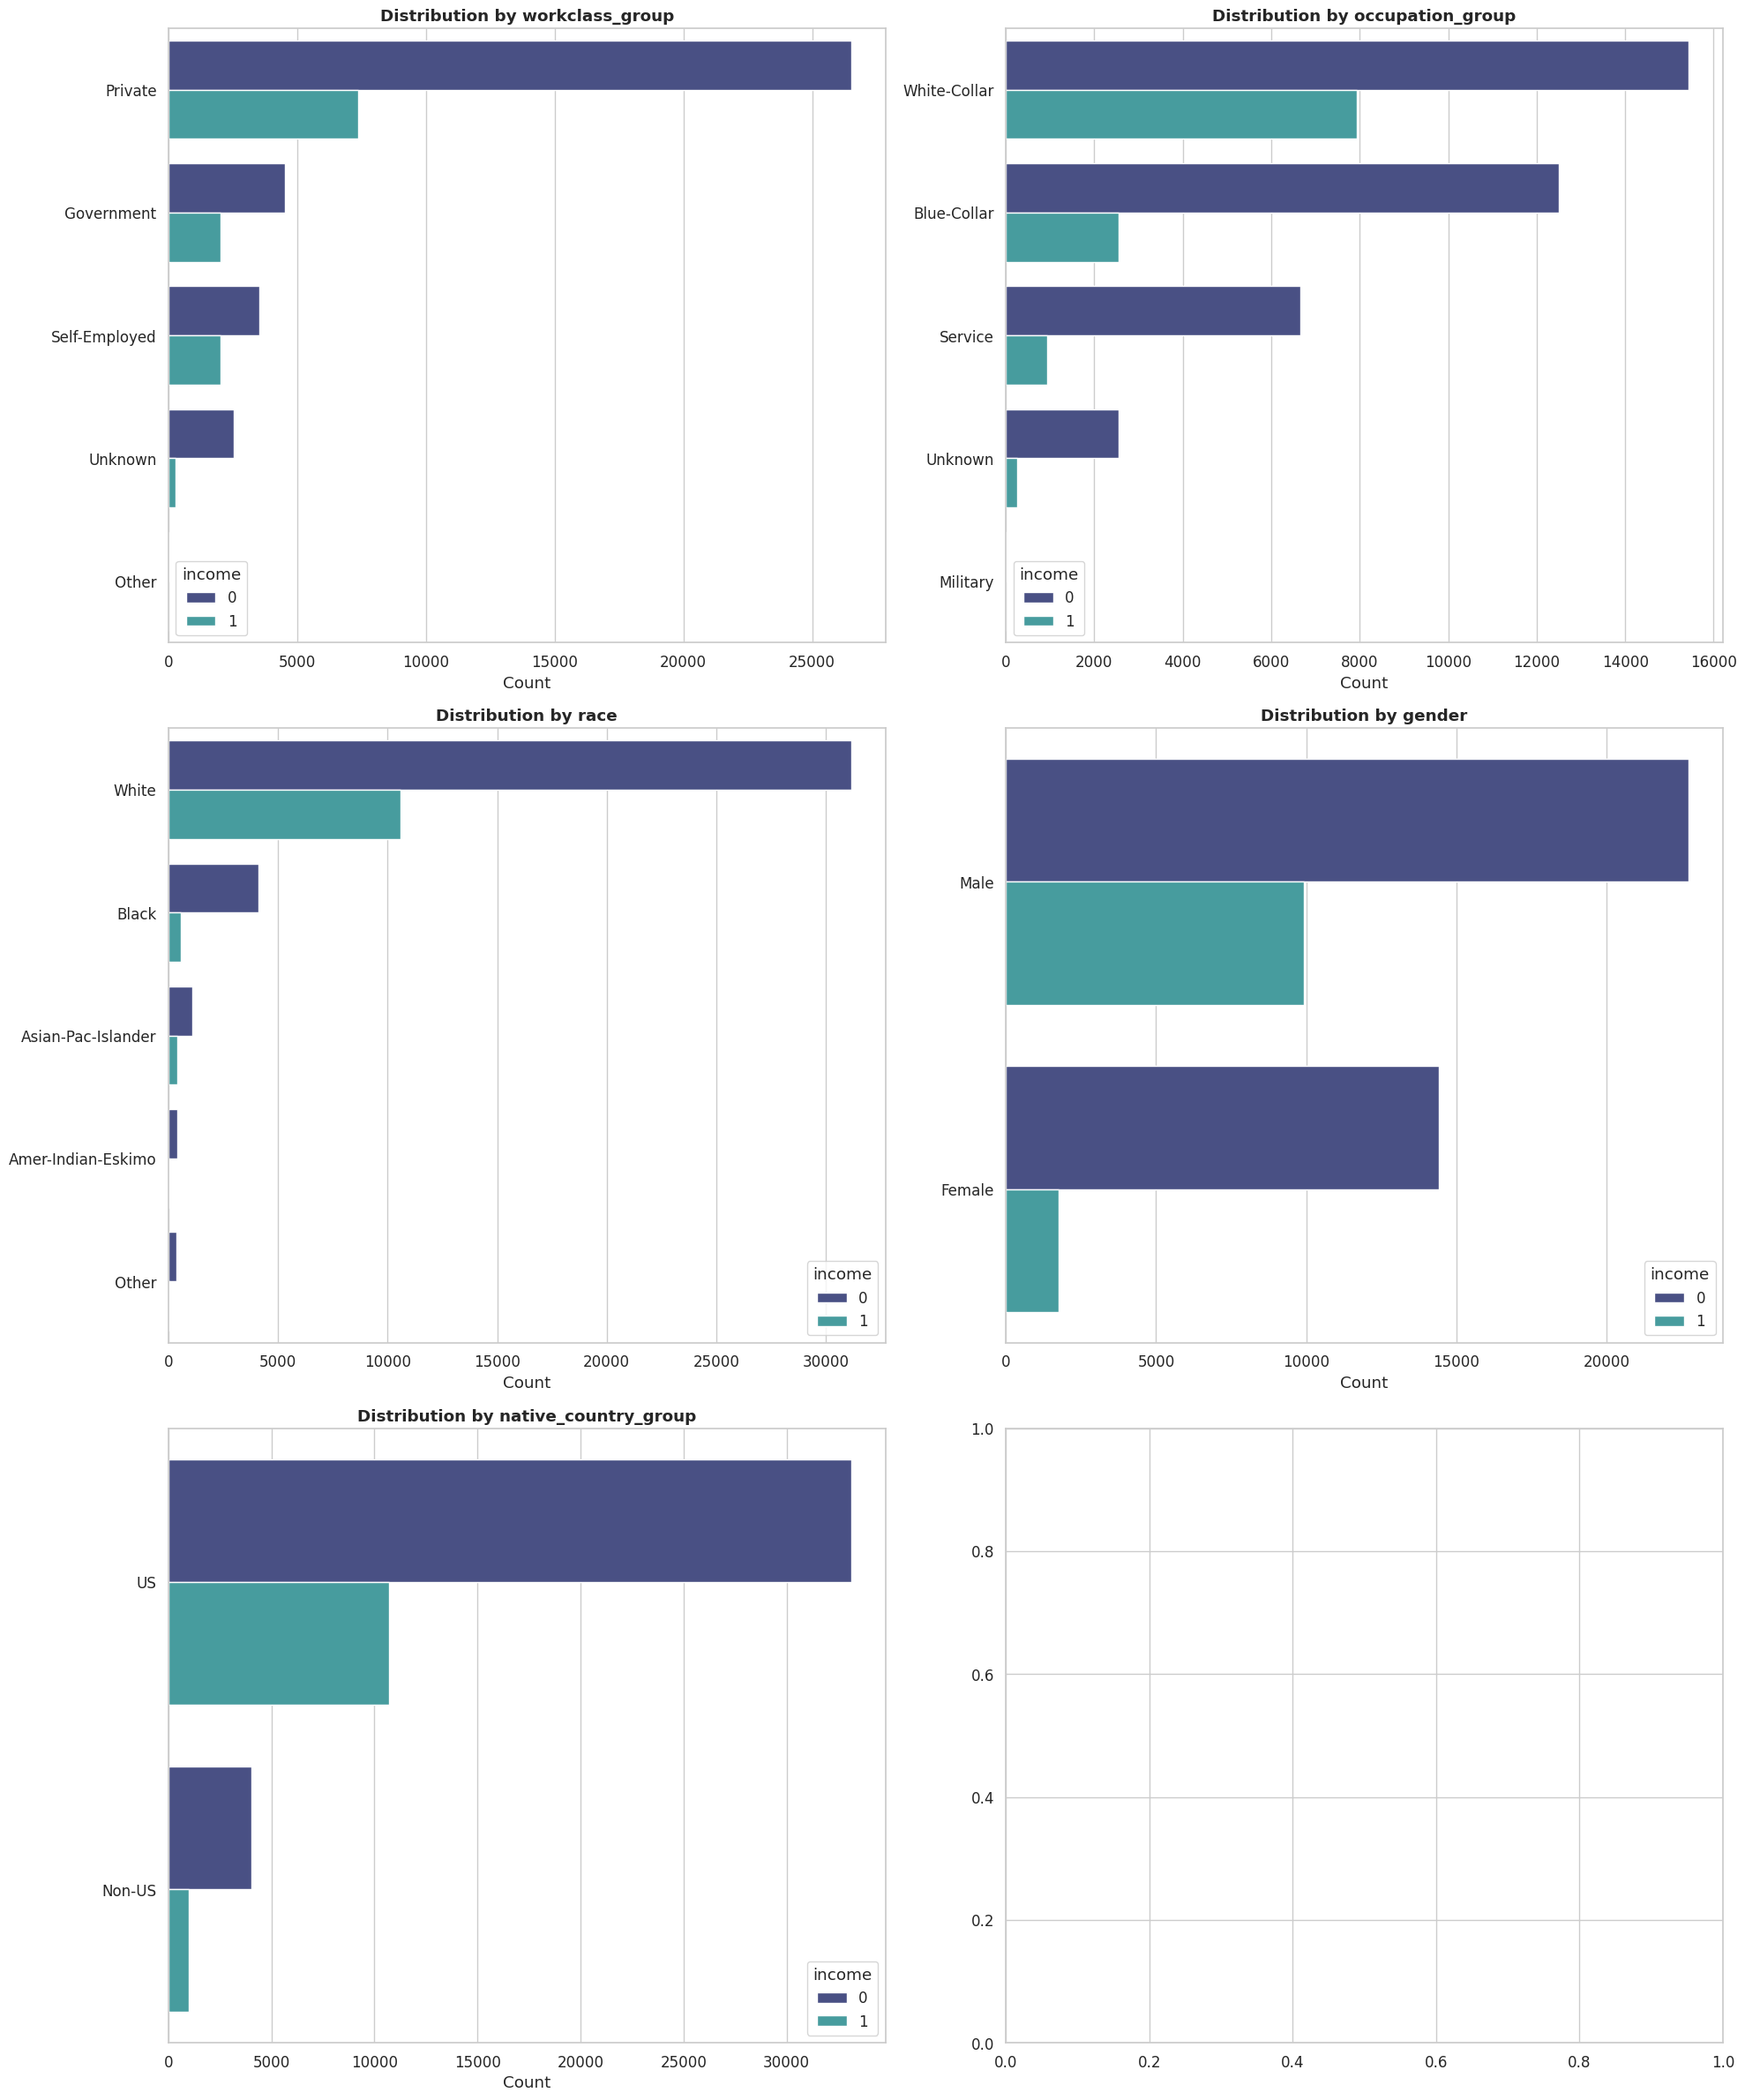

In [21]:
sns.set(style='whitegrid', font_scale=1.1)

cat_cols = [
    'workclass_group', 'occupation_group',
    'race', 'gender', 'native_country_group'
]

fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    order_data = df[col].value_counts().index
    if col == 'native-country':
        order_data = df[col].value_counts().iloc[:15].index

    sns.countplot(
        y=df[col],
        hue=df['income'],
        data=df,
        palette="mako",
        order=order_data,
        ax=axes[i]
    )

    axes[i].set_title(f'Distribution by {col}', fontweight='bold')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Count')

plt.tight_layout()
plt.show()

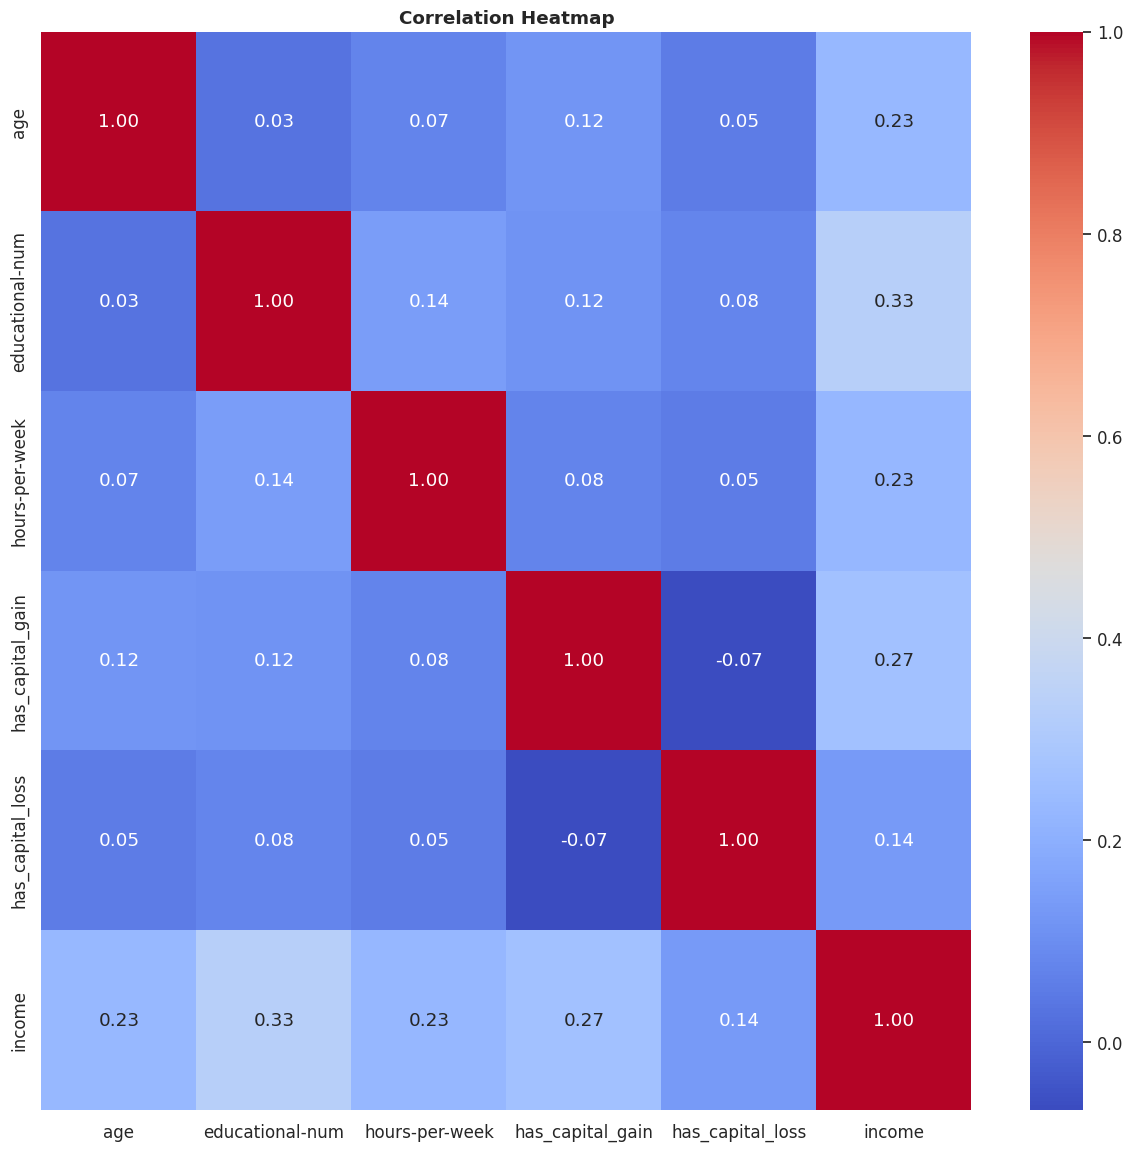

In [22]:
corr_features = [
    'age',
    'educational-num',
    'hours-per-week',
    'has_capital_gain',
    'has_capital_loss',
    'income'
]

sns.set(style='whitegrid', font_scale=1.1)

plt.figure(figsize=(15,14))
sns.heatmap(
    df[corr_features].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)

plt.title('Correlation Heatmap', fontweight='bold')
plt.show()

##Modelling

In [23]:
#split data

X  = df.drop(columns=['income'])
y  = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [24]:
numerical_features = [
    'age',
    'educational-num',
    'hours-per-week'
]

categorical_features = [
    'marital-status',
    'relationship',
    'native_country_group',
    'workclass_group',
    'occupation_group',
    'gender',
    'race'
]

binary_features = [
    'has_capital_gain',
    'has_capital_loss'
]

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)

In [27]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf',
        C=10,
        gamma=0.1,
        random_state=42,
        class_weight='balanced'
    ))
])

svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'educational-num',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['marital-status',
                                                   'relationship',
                                                   'native_country_group',
                                                   'workclass_group',
                                                   'occupation_group', 'gender',
                                                   'race']),
                                                 ('bin', 'passthrough',
                                                  ['has_capital_gain',
                                                   'has_capital_loss'])])),
                ('classifier',
                 SVC(C=10, class_weight='balanced', gamma=0.1,
                     random_state=42))])

In [28]:
y_pred = svm_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"akurasi: {accuracy:.3f}")
print(f"f1 score: {f1:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")

akurasi: 0.786
f1 score: 0.658
precision: 0.532
recall: 0.863


In [29]:
print('classification_report')
print(classification_report(y_test, y_pred))

classification_report
              precision    recall  f1-score   support

           0       0.95      0.76      0.84      7431
           1       0.53      0.86      0.66      2338

    accuracy                           0.79      9769
   macro avg       0.74      0.81      0.75      9769
weighted avg       0.85      0.79      0.80      9769



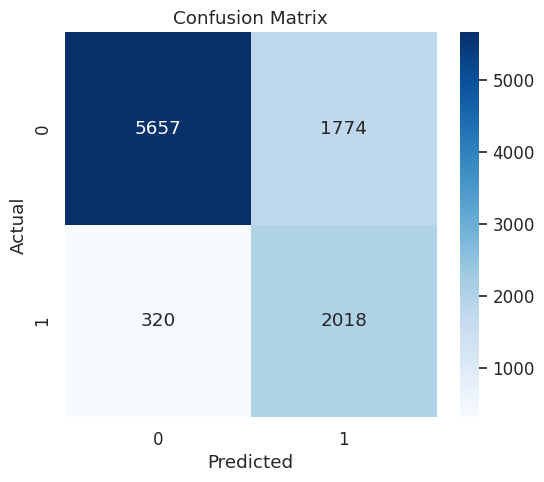

In [30]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

##ROC AUC Curve

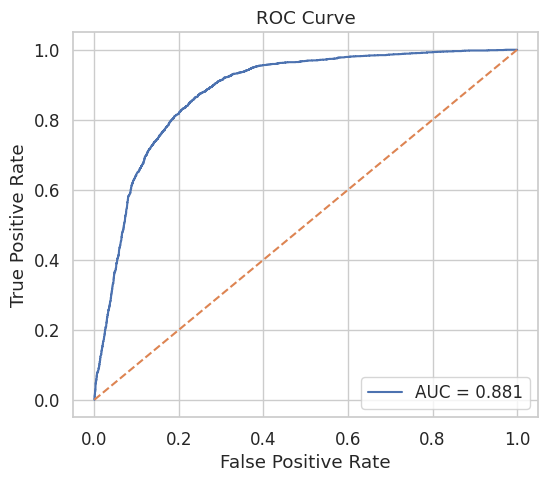

In [31]:
y_score = svm_pipeline.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

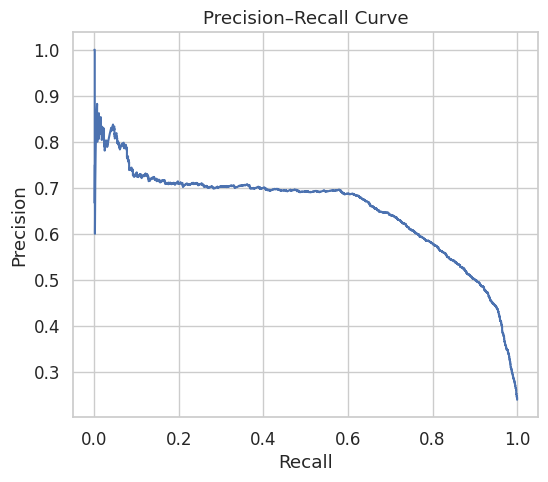

In [32]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

##threshold tuning (precision–recall tradeoff)

In [35]:
y_scores = svm_pipeline.decision_function(X_test)

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [38]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
print(f1_scores)

[0.38622284 0.38625475 0.38628666 ... 0.0017094  0.00085507 0.        ]


In [39]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", f1_scores[best_idx])
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])

Best threshold: 0.7619596009484377
Best F1: 0.6737130504283596
Precision: 0.6210754240346446
Recall: 0.7360992301112061


In [40]:
y_pred_tuned = (y_scores >= best_threshold).astype(int)

In [41]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      7431
           1       0.62      0.74      0.67      2338

    accuracy                           0.83      9769
   macro avg       0.77      0.80      0.78      9769
weighted avg       0.84      0.83      0.83      9769



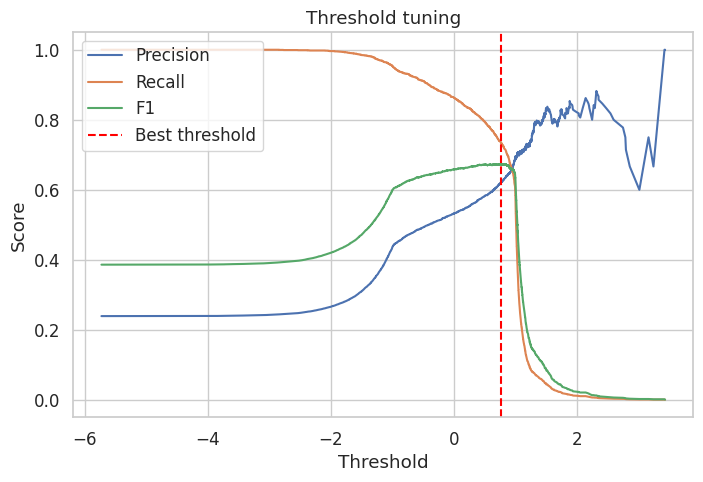

In [42]:

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1')
plt.axvline(best_threshold, color='red', linestyle='--', label='Best threshold')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold tuning")
plt.show()